<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

----

# Preparing the environment

**Note:** This notebook has to be run using the "Python 2 with Spark" kernel on the ESC403 cluster.  If you have started it with another kernel (e.g., "Python 2") restart it by clicking on the menu bar: *Kernel* $\to$ *Change kernel* $\to$ *Python 2 with Spark*.  The Spark-enabled kernel will take a noticeable time to start; this is expected.

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [2]:
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 9)

## Spark Context

The *Python 2 with Spark* kernel already performs all necessary steps to properly initialize [Spark][1].  A global [SparkContext][2] is available in variable `sc`:

[1]: http://spark.apache.org/
[2]: http://spark.apache.org/docs/latest/programming-guide.html#initializing-spark

In [3]:
# (already existing) Spark Context
sc

A `SQLContext` instance is likewise available in the global variable `sqlContext`:

In [4]:
# (already existing) HiveContext
sqlContext

---

# 1. Count filesystem entries recursively

We shall use the "Lustre filesystem" data, which we can extract from the PostGreSQL server by using Spark SQL connector:

In [9]:
df = sqlContext.read.jdbc('jdbc:postgresql://master001/lustre?user=muesim', 'lustre_sample')

The `.take()` and `.collect()` methods allow us to fetch data from a `DataFrame`, in the form of a list of `Row` objects:

In [10]:
df.take(3)

[Row(usr=u'usr388', grp=u'i5105', atime=1384516344, mtime=1384516344, blksize=4, size=1763, path=u'/scratch/bioc/usr388/VS_AllNow_libo_3WAT_end/d491/LIBO00504120_dock012.pdb'),
 Row(usr=u'usr388', grp=u'i5105', atime=1384516344, mtime=1384516344, blksize=4, size=2368, path=u'/scratch/bioc/usr388/VS_AllNow_libo_3WAT_end/d491/LIBO00504133_dock012.pdb'),
 Row(usr=u'usr388', grp=u'i5105', atime=1384516349, mtime=1384516349, blksize=4, size=1708, path=u'/scratch/bioc/usr388/VS_AllNow_libo_3WAT_end/d491/LIBO00504290_dock005.pdb')]

A `Row` object supports data attribute lookup using Python `.` notation:

In [11]:
row0 = df.first()

print(row0.path, row0.size)

(u'/scratch/bioc/usr388/VS_AllNow_libo_3WAT_end/d491/LIBO00504120_dock012.pdb', 1763)


The underlying RDD object can be accessed using the `.rdd` attribute:

In [12]:
df.rdd

MapPartitionsRDD[13] at javaToPython at NativeMethodAccessorImpl.java:-2

Let us re-do an exercise that we already did in the SQL part: **Can you find the directory tree that holds the largest number of files?**

In [13]:
df.printSchema()

root
 |-- usr: string (nullable = false)
 |-- grp: string (nullable = false)
 |-- atime: integer (nullable = true)
 |-- mtime: integer (nullable = true)
 |-- blksize: integer (nullable = true)
 |-- size: long (nullable = true)
 |-- path: string (nullable = true)



---

# 2. Analyzing a Twitter stream

*(This is a much simplified version of a part of the exercise notebook [Uncovering World Events using Twitter Hashtags](https://github.com/rokroskar/spark_workshop/blob/master/notebooks/twitter_dataframes/twitter_dataframes-EMPTY.ipynb) by Rok Roškar)*

A sample extracted from the Twitter datastream of January 2016 is available:

In [159]:
%%time

df = sqlContext.read.json('hdfs:/data/example.small.json')
data = df

CPU times: user 2.29 ms, sys: 349 µs, total: 2.64 ms
Wall time: 14.2 s


Each row contains quite a lot of data, which can be seen by printing out the schema of the loaded `DataFrame` (the schema is inferred by Spark):

In [28]:
df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- delete: struct (nullable = true)
 |    |-- status: struct (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- user_id: long (nullable = true)
 |    |    |-- user_id_str: string (nullable = true)
 |    |-- timestamp_ms: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |  

In [29]:
df2 = df.select('created_at', 'entities.hashtags')

In [126]:
df2.take(5)

[Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[Row(indices=[87, 92], text=u'Royz'), Row(indices=[93, 98], text=u'\u62e1\u6563\u5e0c\u671b')])]

### 1. Keep only tweets which actually *include* hashtags:

In [149]:
import pyspark.sql.functions as func
from pyspark.sql.types import BooleanType, ArrayType, StringType, IntegerType
import datetime

def checkhashtag(x):
    if x is not None and len(x) != 0:
        return True
    else:
        return False

isNotEmpty = func.udf(checkhashtag, returntype=BooleanType())
df3 = df2.where(isNotEmpty(df2.hashtags))
df3.take(5)

[Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[Row(indices=[87, 92], text=u'Royz'), Row(indices=[93, 98], text=u'\u62e1\u6563\u5e0c\u671b')]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[Row(indices=[100, 130], text=u'\u0e2e\u0e32\u0e19\u0e34\u0e04\u0e19\u0e41\u0e21\u0e19\u0e41\u0e1f\u0e19\u0e40\u0e2e\u0e35\u0e22\u0e08\u0e38\u0e19\u0e04\u0e19\u0e21\u0e38\u0e49\u0e07\u0e21\u0e34\u0e49\u0e07')]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[Row(indices=[17, 27], text=u'AskRonnie')]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[Row(indices=[71, 89], text=u'\u5168\u56fd\u306eLDHfam\u3055\u3093\u3068\u7e4b\u304c\u308a\u305f\u3044'), Row(indices=[91, 99], text=u'3\u4ee3\u76ee\u597d\u304d\u306a\u4eba'), Row(indices=[100, 106], text=u'EXILE'), Row(indices=[117, 132], text=u'RT\u3057\u305f\u4eba\u5168\u54e1\u8fce\u3048\u306b\u3044\u304d\u307e\u3059')]),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtags=[Row(indices=[18, 3

### 2. How many unique date/time points are there in the dataset?

From the output above it may seem that all tweets in the dataset were taken at `Fri Jan 01 07:30:00 +0000 2016` -- is this true?

In [151]:
tmp = df.select('created_at')
df4 = tmp.distinct()
print('Number of unique time points: {}'.format(df4.count()))

Number of unique time points: 5401


### 3. Normalize the data frame so that we have a pair timestamp + 1 hashtag per row

In [187]:
hash_text_udf = func.udf(lambda row: [r.text.lower() for r in row], returnType=ArrayType(StringType()))
hashtag_df = (df.select('created_at', 'entities.hashtags')
             .filter(func.size('hashtags') > 0)
             .withColumn('hash_text', hash_text_udf('hashtags'))
             .select('created_at', func.explode('hash_text').alias('hashtag'))
             .withColumn('hashtag', func.lower(func.col('hashtag'))))
hashtag_df.take(5)

[Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtag=u'royz'),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtag=u'\u62e1\u6563\u5e0c\u671b'),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtag=u'\u0e2e\u0e32\u0e19\u0e34\u0e04\u0e19\u0e41\u0e21\u0e19\u0e41\u0e1f\u0e19\u0e40\u0e2e\u0e35\u0e22\u0e08\u0e38\u0e19\u0e04\u0e19\u0e21\u0e38\u0e49\u0e07\u0e21\u0e34\u0e49\u0e07'),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtag=u'askronnie'),
 Row(created_at=u'Fri Jan 01 07:30:00 +0000 2016', hashtag=u'\u5168\u56fd\u306eldhfam\u3055\u3093\u3068\u7e4b\u304c\u308a\u305f\u3044')]

### 4. Convert the timestamp string into a "UNIX epoch" value

The "UNIX epoch timestamp" is defined as the number of seconds elapsed since midnight of January 1st, 1970.

See [this StackOverflow question](http://stackoverflow.com/questions/11743019/convert-python-datetime-to-epoch-with-strftime) for Python code to do the conversion from string to UNIX epoch.

In [257]:
convert_date_to_epoch = func.udf(lambda date_string: 
                                (datetime.datetime.strptime(
                                    date_string, '%a %b %d %H:%M:%S +0000 %Y')
                                 - datetime.datetime(1970, 1, 1)).total_seconds(), StringType())

hashtag_df2 = hashtag_df.select(convert_date_to_epoch('created_at').alias('UNIX epoch value'), 'hashtag')
hashtag_df2.take(5)

[Row(UNIX epoch value=u'1.4516334E9', hashtag=u'royz'),
 Row(UNIX epoch value=u'1.4516334E9', hashtag=u'\u62e1\u6563\u5e0c\u671b'),
 Row(UNIX epoch value=u'1.4516334E9', hashtag=u'\u0e2e\u0e32\u0e19\u0e34\u0e04\u0e19\u0e41\u0e21\u0e19\u0e41\u0e1f\u0e19\u0e40\u0e2e\u0e35\u0e22\u0e08\u0e38\u0e19\u0e04\u0e19\u0e21\u0e38\u0e49\u0e07\u0e21\u0e34\u0e49\u0e07'),
 Row(UNIX epoch value=u'1.4516334E9', hashtag=u'askronnie'),
 Row(UNIX epoch value=u'1.4516334E9', hashtag=u'\u5168\u56fd\u306eldhfam\u3055\u3093\u3068\u7e4b\u304c\u308a\u305f\u3044')]

### 5. How many hashtag were tweeted per second?

In [237]:
df_group = hashtag_df2.groupBy('UNIX epoch value')
df_cnt = df_group.count()
df_cnt.take(5)

[Row(UNIX epoch value=u'1.451634404E9', count=14),
 Row(UNIX epoch value=u'1.45163464E9', count=12),
 Row(UNIX epoch value=u'1.451634693E9', count=5),
 Row(UNIX epoch value=u'1.451634855E9', count=4),
 Row(UNIX epoch value=u'1.451635089E9', count=3)]

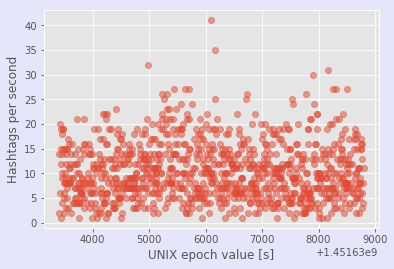

In [250]:
cnt_data = df_cnt.toPandas()
ulim = 1000
fig, ax = plt.subplots(facecolor='lavender')
plt.plot(cnt_data['UNIX epoch value'][:ulim], cnt_data['count'][:ulim], 'o', alpha=0.5)
plt.xlabel('UNIX epoch value [s]')
plt.ylabel('Hashtags per second')

In [256]:
import numpy as np
cnt_mean = np.mean(cnt_data['count'])
print('Average # of tweets per second: {:.0f}'.format(cnt_mean))

Average # of tweets per second: 11
